# Proyek Klasifikasi Gambar: [Intel Image clasification]
- **Nama:** Titi Prihartati
- **Email:** titiprihartati@gmail.com
- **ID Dicoding:** MC223d5X0527

# Sumber data set :
https://www.kaggle.com/datasets/puneet6060/intel-image-classification

## Import Semua Packages/Library yang Digunakan

In [2]:
!pip install tensorflowjs

In [3]:
from google.colab import files
import os
import shutil
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import tensorflowjs as tfjs
from PIL import Image
from skimage import io, img_as_ubyte
from skimage.transform import rotate, warp, AffineTransform
from skimage.exposure import adjust_gamma
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm  # buat progress bar
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [4]:
# Mencetak versi TensorFlow yang sedang digunakan
print(tf.__version__)

2.18.0


# Data Preparation

## Data Loading

In [5]:
from google.colab import files
files.upload()

Saving kaggle (14).json to kaggle (14).json


{'kaggle (14).json': b'{"username":"tiprihartati","key":"b49a27cd4c9a8e5b033ee43cd28a106a"}'}

In [6]:
!mv "kaggle (14).json" kaggle.json
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
# Download dataset dari Kaggle
!kaggle datasets download -d puneet6060/intel-image-classification

# Unzip dataset (pastikan nama file sesuai hasil dari kaggle)
!unzip intel-image-classification.zip -d /content/

Output streaming akan dipotong hingga 5000 baris terakhir.
  inflating: /content/seg_train/seg_train/mountain/7506.jpg  
  inflating: /content/seg_train/seg_train/mountain/7537.jpg  
  inflating: /content/seg_train/seg_train/mountain/7539.jpg  
  inflating: /content/seg_train/seg_train/mountain/7551.jpg  
  inflating: /content/seg_train/seg_train/mountain/7560.jpg  
  inflating: /content/seg_train/seg_train/mountain/7565.jpg  
  inflating: /content/seg_train/seg_train/mountain/7578.jpg  
  inflating: /content/seg_train/seg_train/mountain/7581.jpg  
  inflating: /content/seg_train/seg_train/mountain/7586.jpg  
  inflating: /content/seg_train/seg_train/mountain/7647.jpg  
  inflating: /content/seg_train/seg_train/mountain/7652.jpg  
  inflating: /content/seg_train/seg_train/mountain/7654.jpg  
  inflating: /content/seg_train/seg_train/mountain/7662.jpg  
  inflating: /content/seg_train/seg_train/mountain/767.jpg  
  inflating: /content/seg_train/seg_train/mountain/7672.jpg  
  inflating:

In [8]:
import os

base_path = '/content/seg_train'
classes = os.listdir(base_path)
print("Kelas yang tersedia:", classes)


Kelas yang tersedia: ['seg_train']


In [9]:
for cls in classes:
    path = os.path.join(base_path, cls)
    print(f"{cls}: {len(os.listdir(path))} gambar")


seg_train: 6 gambar


## gabungkan data

In [10]:
import os
import shutil

# Folder sumber
train_dir = "/content/seg_train/seg_train"
test_dir = "/content/seg_test/seg_test"

# Folder gabungan baru
combined_dir = "/content/combined_data"
os.makedirs(combined_dir, exist_ok=True)

# Gabungkan dari train
for cls in os.listdir(train_dir):
    src_cls = os.path.join(train_dir, cls)
    dst_cls = os.path.join(combined_dir, cls)
    os.makedirs(dst_cls, exist_ok=True)

    for file in os.listdir(src_cls):
        src_file = os.path.join(src_cls, file)
        if os.path.isfile(src_file):
            shutil.copy(src_file, os.path.join(dst_cls, file))

# Gabungkan dari test
for cls in os.listdir(test_dir):
    src_cls = os.path.join(test_dir, cls)
    dst_cls = os.path.join(combined_dir, cls)
    os.makedirs(dst_cls, exist_ok=True)

    for file in os.listdir(src_cls):
        src_file = os.path.join(src_cls, file)
        if os.path.isfile(src_file):
            shutil.copy(src_file, os.path.join(dst_cls, file))


## plot gambar Sample data

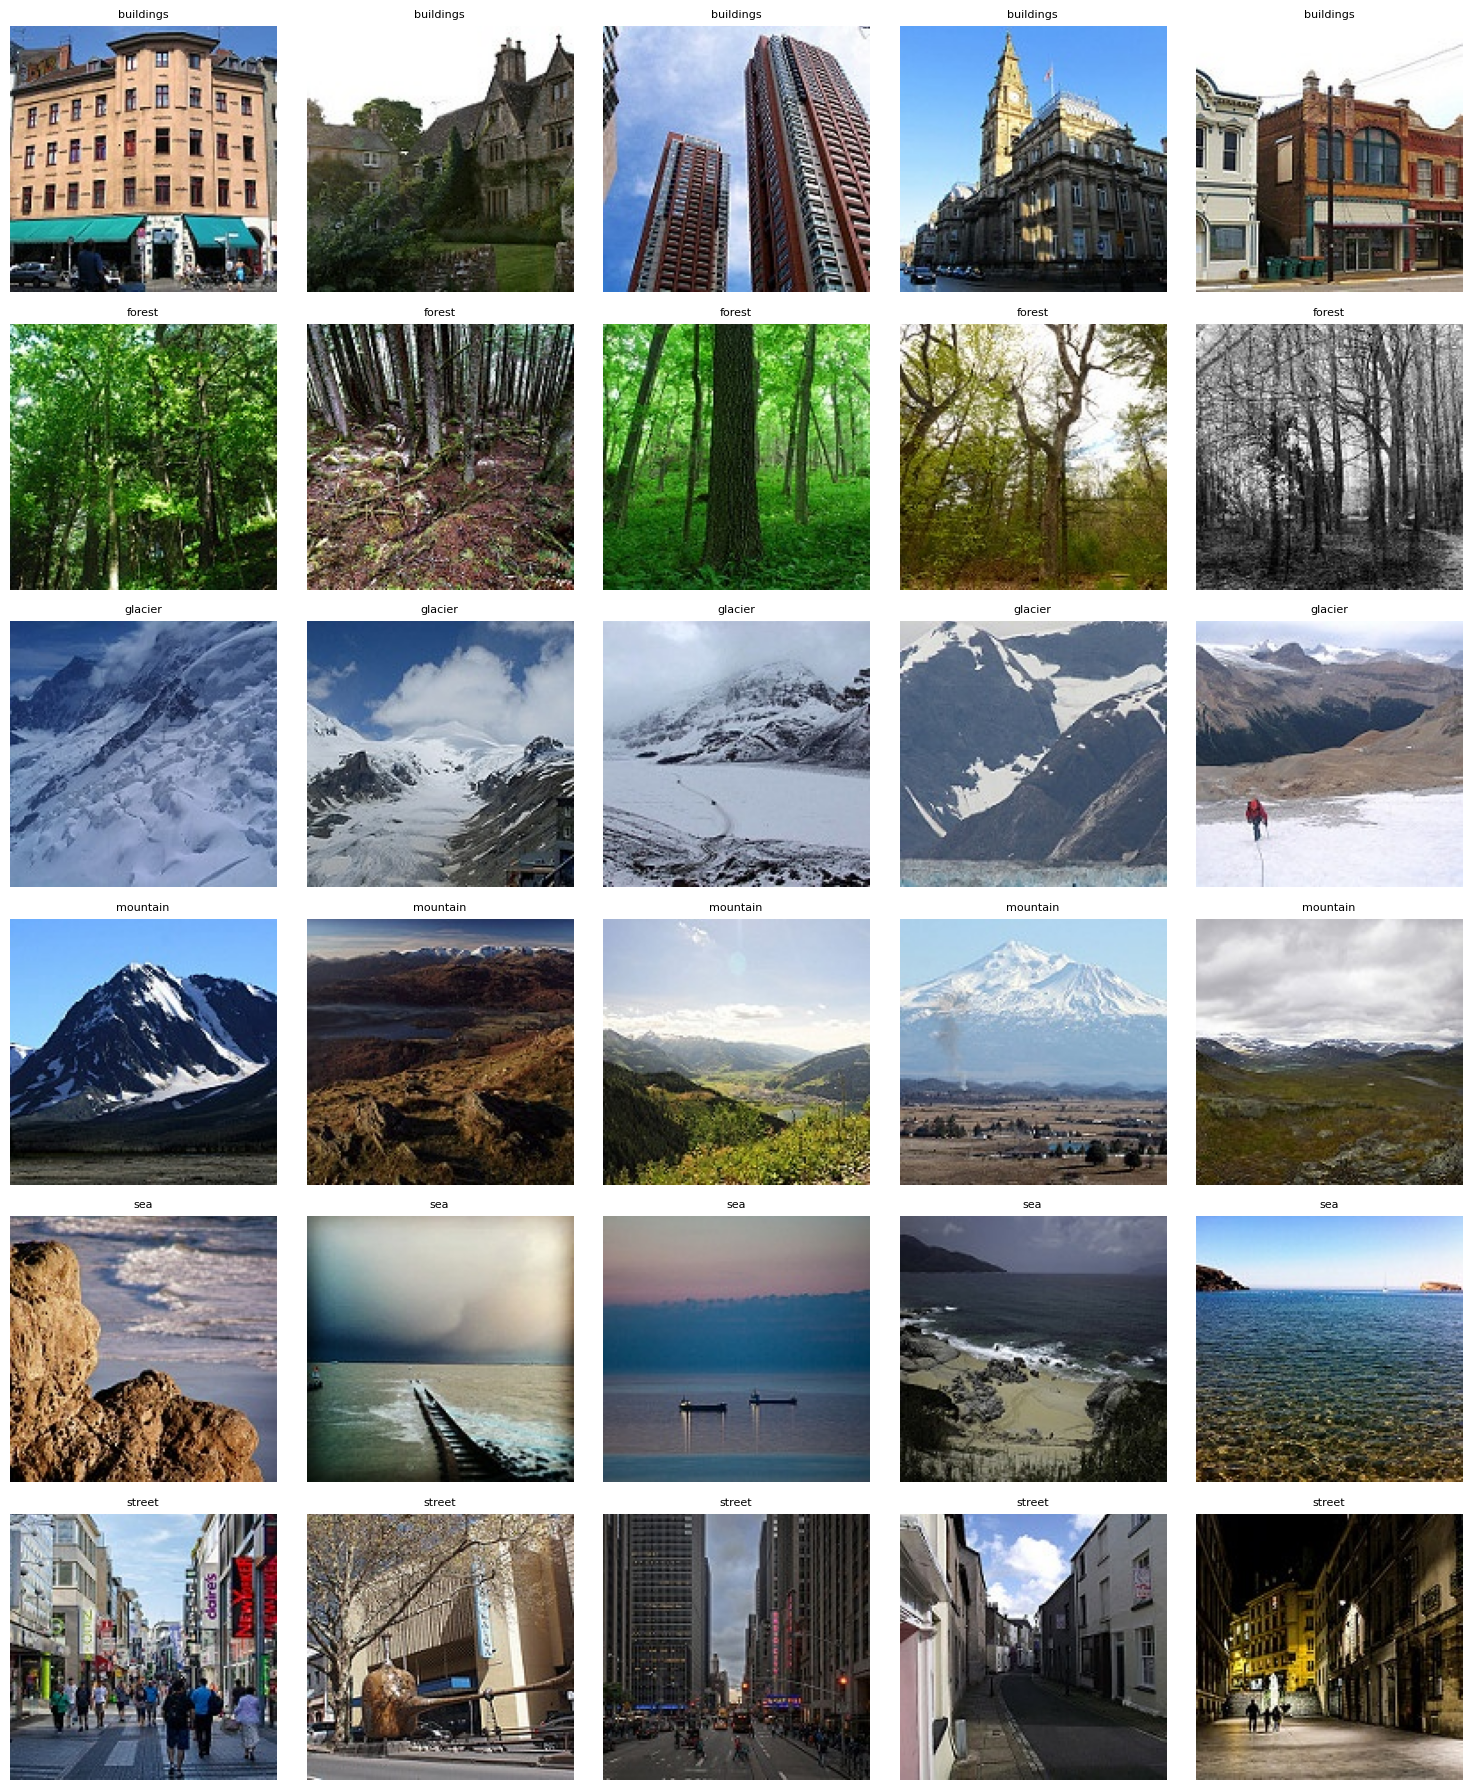

In [11]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Path dataset hasil gabungan
dataset_path = '/content/combined_data'

# Hanya ambil 5 kelas yang diinginkan
selected_classes = ['buildings','mountain', 'glacier', 'street', 'sea', 'forest']

# Membuat kamus gambar per kelas
class_images = {}

for class_name in selected_classes:
    class_path = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_path):
        image_paths = [
            os.path.join(class_path, img)
            for img in os.listdir(class_path)
            if img.lower().endswith(('.png', '.jpg', '.jpeg'))
        ]
        if len(image_paths) >= 5:
            class_images[class_name] = image_paths

# Plot 5 gambar acak dari setiap kelas
fig, axs = plt.subplots(len(class_images), 5, figsize=(15, len(class_images)*3))

for i, class_name in enumerate(sorted(class_images.keys())):
    images = np.random.choice(class_images[class_name], 5, replace=False)
    for j, image_path in enumerate(images):
        img = Image.open(image_path).convert("RGB")
        axs[i, j].imshow(img)
        axs[i, j].set_title(class_name, fontsize=8)
        axs[i, j].axis('off')

plt.tight_layout()
plt.show()


## plot distribusi

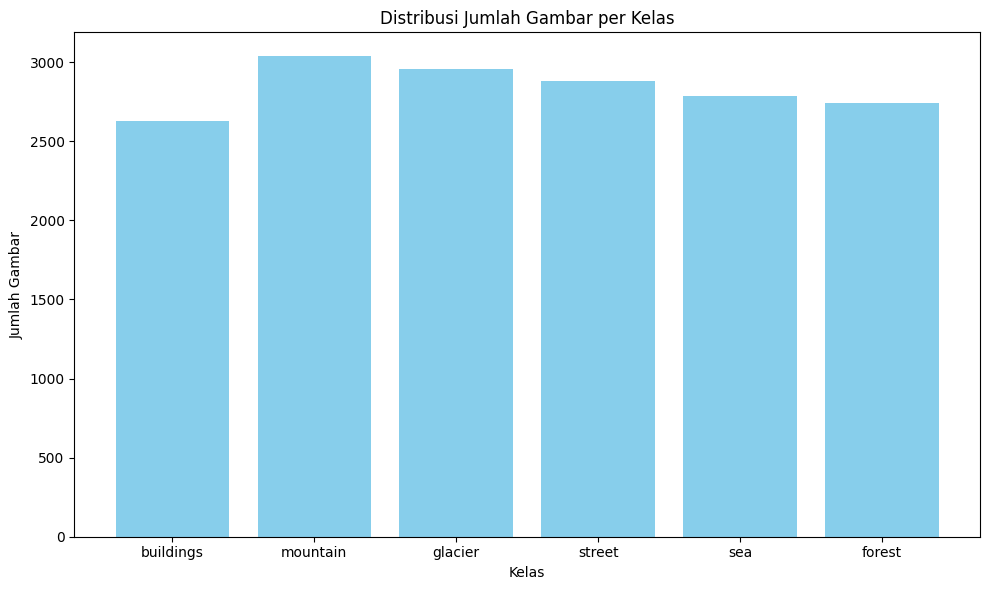

In [12]:
import os
import matplotlib.pyplot as plt

# Path dataset hasil gabungan
dataset_path = '/content/combined_data'

# Kelas yang ingin dipilih
selected_classes = ['buildings','mountain', 'glacier', 'street', 'sea', 'forest']

# Menyimpan jumlah gambar per kelas
class_counts = {}

for class_name in selected_classes:
    class_path = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_path):
        image_count = len([img for img in os.listdir(class_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))])
        class_counts[class_name] = image_count

# Menampilkan plot distribusi kelas
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(class_counts.keys(), class_counts.values(), color='skyblue')

# Menambahkan label dan judul
ax.set_xlabel('Kelas')
ax.set_ylabel('Jumlah Gambar')
ax.set_title('Distribusi Jumlah Gambar per Kelas')

plt.tight_layout()
plt.show()


# Data Prepocessing

## Split data set

In [13]:
import os
import pandas as pd

# Path dataset hasil gabungan
mypath = '/content/combined_data'

# Menampung informasi gambar
file_name = []
labels = []
full_path = []

# Loop melalui subfolder (kelas) dan file dalam folder tersebut
for path, subdirs, files in os.walk(mypath):
    for name in files:
        # Menyimpan path gambar dan label kelas
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])  # Mengambil nama kelas (folder terakhir)
        file_name.append(name)

# Memasukkan variabel yang sudah dikumpulkan pada looping di atas menjadi sebuah dataframe
df = pd.DataFrame({"path": full_path, 'file_name': file_name, "labels": labels})

# Menampilkan jumlah data gambar per label (kelas)
print(df.groupby(['labels']).size())


labels
buildings    2628
forest       2745
glacier      2957
mountain     3037
sea          2784
street       2883
dtype: int64


In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Variabel x = path gambar, y = labels (nama kelas)
x = df['path']
y = df['labels']

# Split dataset menjadi data train dan test
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=300)

# Buat DataFrame untuk training dan testing
df_tr = pd.DataFrame({'path': x_train, 'labels': y_train, 'set': 'train'})
df_te = pd.DataFrame({'path': x_test, 'labels': y_test, 'set': 'test'})

# Gabungkan DataFrame df_tr dan df_te
all_df = pd.concat([df_tr, df_te], ignore_index=True)

# Tampilkan jumlah data per set dan label
print(all_df.groupby(['set', 'labels']).size(), '\n')

# Cek sampel data
print(all_df.sample(10))

# Tentukan path sumber dataset yang telah dipisah (gabungan data)
dataset_path = "/content/combined_data"  # Ganti sesuai lokasi dataset gabungan

# Membuat folder baru untuk dataset final
final_dataset_path = "/content/Dataset-Final"

# Pastikan folder tujuan sudah ada
os.makedirs(final_dataset_path, exist_ok=True)


set    labels   
test   buildings     513
       forest        547
       glacier       608
       mountain      619
       sea           556
       street        564
train  buildings    2115
       forest       2198
       glacier      2349
       mountain     2418
       sea          2228
       street       2319
dtype: int64 

                                            path     labels    set
5066     /content/combined_data/forest/22833.jpg     forest  train
3742     /content/combined_data/forest/23465.jpg     forest  train
755         /content/combined_data/sea/11592.jpg        sea  train
7767   /content/combined_data/buildings/9281.jpg  buildings  train
45       /content/combined_data/street/10202.jpg     street  train
4843      /content/combined_data/street/6240.jpg     street  train
1264    /content/combined_data/mountain/8126.jpg   mountain  train
11948   /content/combined_data/mountain/1721.jpg   mountain  train
14253   /content/combined_data/glacier/11586.jpg    glacier   tes

In [15]:
from tqdm import tqdm

In [16]:
for index, row in tqdm(all_df.iterrows(), total=all_df.shape[0]):
    # Deteksi filepath
    file_path = row['path']
    if os.path.exists(file_path) == False:
            file_path = os.path.join(datasource_path,row['labels'],row['image'].split('.')[0])

    # Buat direktori tujuan folder
    if os.path.exists(os.path.join(dataset_path,row['set'],row['labels'])) == False:
        os.makedirs(os.path.join(dataset_path,row['set'],row['labels']))

    # Tentukan tujuan file
    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(dataset_path,row['set'],row['labels'],destination_file_name)

    # Salin file dari sumber ke tujuan
    if os.path.exists(file_dest) == False:
        shutil.copy2(file_path,file_dest)

100%|██████████| 17034/17034 [00:04<00:00, 3943.71it/s]


In [17]:
import os
import shutil
from tqdm import tqdm
import pandas as pd
from sklearn.model_selection import train_test_split

# Path dataset hasil gabungan
datasource_path = '/content/combined_data'  # Sesuaikan dengan lokasi dataset gabungan
dataset_path = '/content/Dataset-Final'  # Path tujuan untuk data train/test
train_dir = os.path.join(dataset_path, 'train')
test_dir = os.path.join(dataset_path, 'test')

# Bersihkan folder train dan test jika sudah ada
if os.path.exists(train_dir):
    shutil.rmtree(train_dir)
if os.path.exists(test_dir):
    shutil.rmtree(test_dir)

os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Fungsi ambil seluruh path gambar dari dataset
def get_distribution(path):
    file_name = []
    labels = []
    full_path = []

    for path_dir, subdirs, files in os.walk(path):
        for name in files:
            # Filter file dengan ekstensi gambar
            if name.lower().endswith(('.jpg', '.jpeg', '.png')):
                full_path.append(os.path.join(path_dir, name))
                labels.append(os.path.basename(path_dir))  # Ambil nama folder sebagai label
                file_name.append(name)

    return pd.DataFrame({"path": full_path, 'file_name': file_name, "labels": labels})

# Load data dari dataset gabungan
df = get_distribution(datasource_path)  # Pastikan path ke data gabungan sudah benar

# Split data ke train dan test
x_train, x_test, y_train, y_test = train_test_split(
    df['path'], df['labels'], test_size=0.2, random_state=42, stratify=df['labels']
)

# Satukan ke dataframe
train_df = pd.DataFrame({'path': x_train, 'labels': y_train, 'set': 'train'})
test_df = pd.DataFrame({'path': x_test, 'labels': y_test, 'set': 'test'})
all_df = pd.concat([train_df, test_df]).reset_index(drop=True)

# --- Copy file ke folder train/test masing-masing ---
for idx, row in tqdm(all_df.iterrows(), total=len(all_df)):
    src_path = row['path']
    label = row['labels']
    dataset_type = row['set']

    # Tentukan folder tujuan
    dest_dir = os.path.join(train_dir if dataset_type == 'train' else test_dir, label)
    os.makedirs(dest_dir, exist_ok=True)

    # Nama file tujuan
    dest_path = os.path.join(dest_dir, os.path.basename(src_path))

    # Cek apakah file sumber ada, lalu salin ke tujuan
    if os.path.exists(src_path):
        shutil.copy2(src_path, dest_path)
    else:
        print(f"Warning: File tidak ditemukan -> {src_path}")

print("=== Semua file berhasil disalin ke train/test ===")


100%|██████████| 34068/34068 [00:10<00:00, 3166.44it/s]

=== Semua file berhasil disalin ke train/test ===


# Modelling

In [19]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    "Dataset-Final/train",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset="training"
)

val_generator = train_datagen.flow_from_directory(
    "Dataset-Final/train",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset="validation"
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    "Dataset-Final/test",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)
base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze pretrained layer

# Model Sequential lengkap dengan Conv2D & MaxPooling2D setelah MobileNet
model = Sequential([
    Input(shape=(224, 224, 3)),
    base_model,

    # Tambahkan Conv2D & Pooling setelah pretrained model
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),

    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(6, activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
earlystop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('mobilenetv2_sequential_best.h5', monitor='val_accuracy', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Train model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[earlystop, checkpoint, reduce_lr]
)


Found 13091 images belonging to 6 classes.
Found 3271 images belonging to 6 classes.
Found 6142 images belonging to 6 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
410/410 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step - accuracy: 0.4878 - loss: 1.3256

410/410 ━━━━━━━━━━━━━━━━━━━━ 270s 628ms/step - accuracy: 0.4881 - loss: 1.3247 - val_accuracy: 0.8710 - val_loss: 0.3677 - learning_rate: 1.0000e-04
Epoch 2/20
410/410 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 0.7923 - loss: 0.5913

410/410 ━━━━━━━━━━━━━━━━━━━━ 200s 489ms/step - accuracy: 0.7923 - loss: 0.5913 - val_accuracy: 0.8930 - val_loss: 0.3159 - learning_rate: 1.0000e-04
Epoch 3/20
410/410 ━━━━━━━━━━━━━━━━━━━━ 201s 492ms/step - accuracy: 0.8349 - loss: 0.4920 - val_accuracy: 0.8872 - val_loss: 0.3063 - learning_rate: 1.0000e-04
Epoch 4/20
410/410 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - accuracy: 0.8472 - loss: 0.4584

410/410 ━━━━━━━━━━━━━━━━━━━━ 201s 490ms/step - accuracy: 0.8472 - loss: 0.4584 - val_accuracy: 0.8997 - val_loss: 0.2939 - learning_rate: 1.0000e-04
Epoch 5/20
410/410 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - accuracy: 0.8555 - loss: 0.4168

410/410 ━━━━━━━━━━━━━━━━━━━━ 203s 495ms/step - accuracy: 0.8555 - loss: 0.4167 - val_accuracy: 0.9034 - val_loss: 0.2934 - learning_rate: 1.0000e-04
Epoch 6/20
410/410 ━━━━━━━━━━━━━━━━━━━━ 200s 488ms/step - accuracy: 0.8628 - loss: 0.3939 - val_accuracy: 0.8945 - val_loss: 0.2956 - learning_rate: 1.0000e-04
Epoch 7/20
410/410 ━━━━━━━━━━━━━━━━━━━━ 211s 515ms/step - accuracy: 0.8631 - loss: 0.4005 - val_accuracy: 0.8902 - val_loss: 0.2964 - learning_rate: 1.0000e-04
Epoch 8/20
410/410 ━━━━━━━━━━━━━━━━━━━━ 201s 489ms/step - accuracy: 0.8678 - loss: 0.3758 - val_accuracy: 0.8933 - val_loss: 0.2903 - learning_rate: 1.0000e-04
Epoch 9/20
410/410 ━━━━━━━━━━━━━━━━━━━━ 204s 497ms/step - accuracy: 0.8705 - loss: 0.3750 - val_accuracy: 0.8921 - val_loss: 0.2904 - learning_rate: 1.0000e-04
Epoch 10/20
410/410 ━━━━━━━━━━━━━━━━━━━━ 201s 491ms/step - accuracy: 0.8711 - loss: 0.3624 - val_accuracy: 0.8973 - val_loss: 0.2939 - learning_rate: 1.0000e-04
Epoch 11/20
410/410 ━━━━━━━━━━━━━━━━━━━━ 203s 496m

410/410 ━━━━━━━━━━━━━━━━━━━━ 201s 491ms/step - accuracy: 0.8887 - loss: 0.3182 - val_accuracy: 0.9037 - val_loss: 0.2667 - learning_rate: 1.0000e-04
Epoch 15/20
410/410 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 0.8887 - loss: 0.3138

410/410 ━━━━━━━━━━━━━━━━━━━━ 200s 488ms/step - accuracy: 0.8887 - loss: 0.3138 - val_accuracy: 0.9077 - val_loss: 0.2563 - learning_rate: 1.0000e-04
Epoch 16/20
410/410 ━━━━━━━━━━━━━━━━━━━━ 203s 494ms/step - accuracy: 0.8924 - loss: 0.3084 - val_accuracy: 0.9028 - val_loss: 0.2796 - learning_rate: 1.0000e-04
Epoch 17/20
410/410 ━━━━━━━━━━━━━━━━━━━━ 200s 489ms/step - accuracy: 0.8921 - loss: 0.3163 - val_accuracy: 0.9077 - val_loss: 0.2624 - learning_rate: 1.0000e-04
Epoch 18/20
410/410 ━━━━━━━━━━━━━━━━━━━━ 201s 490ms/step - accuracy: 0.8928 - loss: 0.2983 - val_accuracy: 0.9061 - val_loss: 0.2713 - learning_rate: 1.0000e-04
Epoch 19/20
410/410 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - accuracy: 0.9025 - loss: 0.2862

410/410 ━━━━━━━━━━━━━━━━━━━━ 202s 492ms/step - accuracy: 0.9025 - loss: 0.2862 - val_accuracy: 0.9083 - val_loss: 0.2625 - learning_rate: 2.0000e-05
Epoch 20/20
410/410 ━━━━━━━━━━━━━━━━━━━━ 207s 505ms/step - accuracy: 0.9023 - loss: 0.2747 - val_accuracy: 0.9065 - val_loss: 0.2613 - learning_rate: 2.0000e-05


#Evaluasi

In [20]:
for i in range(len(history.history['accuracy'])):
    epoch = i + 1
    train_acc = history.history['accuracy'][i]
    val_acc = history.history['val_accuracy'][i]
    train_loss = history.history['loss'][i]
    val_loss = history.history['val_loss'][i]
    print(f"Epoch {epoch:02d} - Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")


Epoch 01 - Train Acc: 0.6356, Val Acc: 0.8710, Train Loss: 0.9615, Val Loss: 0.3677
Epoch 02 - Train Acc: 0.8040, Val Acc: 0.8930, Train Loss: 0.5650, Val Loss: 0.3159
Epoch 03 - Train Acc: 0.8366, Val Acc: 0.8872, Train Loss: 0.4855, Val Loss: 0.3063
Epoch 04 - Train Acc: 0.8477, Val Acc: 0.8997, Train Loss: 0.4448, Val Loss: 0.2939
Epoch 05 - Train Acc: 0.8578, Val Acc: 0.9034, Train Loss: 0.4165, Val Loss: 0.2934
Epoch 06 - Train Acc: 0.8643, Val Acc: 0.8945, Train Loss: 0.3966, Val Loss: 0.2956
Epoch 07 - Train Acc: 0.8640, Val Acc: 0.8902, Train Loss: 0.3981, Val Loss: 0.2964
Epoch 08 - Train Acc: 0.8713, Val Acc: 0.8933, Train Loss: 0.3724, Val Loss: 0.2903
Epoch 09 - Train Acc: 0.8746, Val Acc: 0.8921, Train Loss: 0.3640, Val Loss: 0.2904
Epoch 10 - Train Acc: 0.8761, Val Acc: 0.8973, Train Loss: 0.3525, Val Loss: 0.2939
Epoch 11 - Train Acc: 0.8805, Val Acc: 0.9000, Train Loss: 0.3422, Val Loss: 0.2799
Epoch 12 - Train Acc: 0.8843, Val Acc: 0.9006, Train Loss: 0.3400, Val Loss:

In [21]:
# Evaluasi model pada data test
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


192/192 ━━━━━━━━━━━━━━━━━━━━ 13s 67ms/step - accuracy: 0.9266 - loss: 0.1939

Test Loss: 0.2044
Test Accuracy: 0.9253


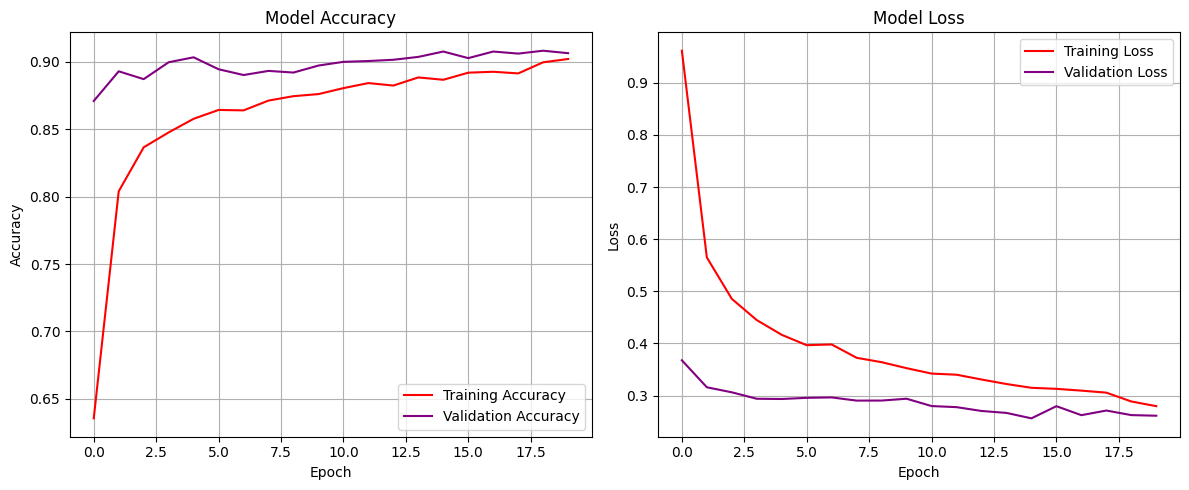

In [22]:
import matplotlib.pyplot as plt

# Plot akurasi
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', color = 'red')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy',color = 'purple')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', color = 'red')
plt.plot(history.history['val_loss'], label='Validation Loss', color = 'purple')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


192/192 ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/step


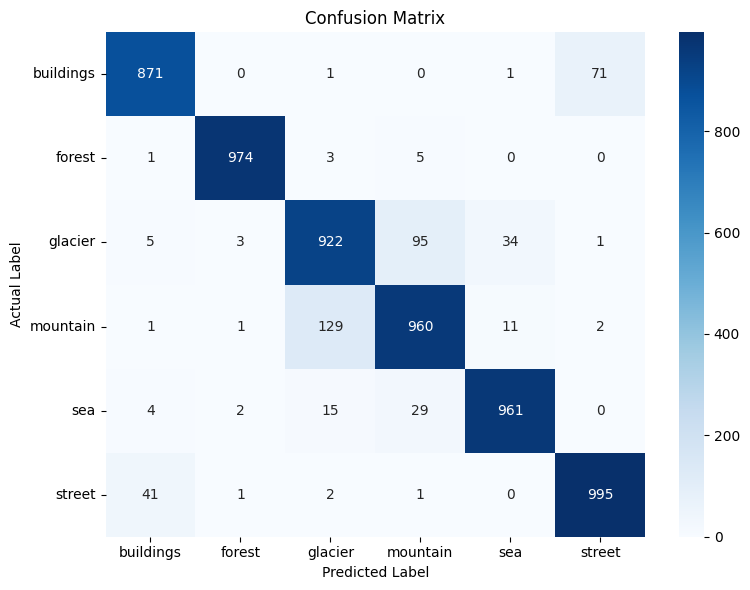


Classification Report:

              precision    recall  f1-score   support

   buildings     0.9437    0.9227    0.9330       944
      forest     0.9929    0.9908    0.9919       983
     glacier     0.8601    0.8698    0.8649      1060
    mountain     0.8807    0.8696    0.8751      1104
         sea     0.9543    0.9505    0.9524      1011
      street     0.9308    0.9567    0.9436      1040

    accuracy                         0.9253      6142
   macro avg     0.9271    0.9267    0.9268      6142
weighted avg     0.9254    0.9253    0.9253      6142



In [23]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Reset generator sebelum prediksi
test_generator.reset()

# Prediksi data test
preds = model.predict(test_generator, verbose=1)

# Ambil prediksi kelas (dari probabilitas ke label class)
preds_class = np.argmax(preds, axis=1)

# Buat Confusion Matrix
cm = confusion_matrix(test_generator.classes, preds_class)

# Ambil nama-nama kelas
target_names = list(train_generator.class_indices.keys())

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=target_names,
            yticklabels=target_names)
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Print Classification Report
print("\nClassification Report:\n")
print(classification_report(
    y_true=test_generator.classes,
    y_pred=preds_class,
    target_names=target_names,
    digits=4
))


# Konversi

In [24]:
# Menyimpan dalam format SavedModel
tf.saved_model.save(model, 'model_final_savedmodel')

# Menyimpan dalam format TF-Lite
converter = tf.lite.TFLiteConverter.from_saved_model('model_final_savedmodel')  # Remove experimental_new_converter
# ... (Optional: converter settings) ...
tflite_model = converter.convert()
with open('model_final.tflite', 'wb') as f:
    f.write(tflite_model)

# Menyimpan dalam format TFJS
tfjs.converters.save_keras_model(model, 'model_final_tfjs')

print("Model berhasil disimpan dalam format SavedModel, TF-Lite, dan TFJS.")

failed to lookup keras version from the file,
    this is likely a weight only file
Model berhasil disimpan dalam format SavedModel, TF-Lite, dan TFJS.


Model berhasil disimpan ke 'saved_model_final.h5'.


Model berhasil dimuat ulang untuk inference.


Saving 1003.jpg to 1003.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Prediksi Kelas: sea


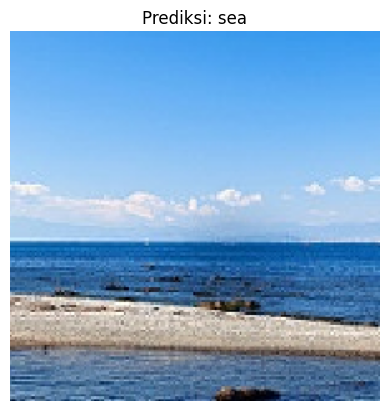

In [25]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from google.colab import files
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# === 1. Simpan Model ===
model.save('saved_model_final.h5')  # Gunakan hanya .h5 jika ingin format HDF5
print("Model berhasil disimpan ke 'saved_model_final.h5'.")

# === 2. Load Model ===
inference_model = load_model('saved_model_final.h5')
print("Model berhasil dimuat ulang untuk inference.")

# === 3. Inference pada 1 Gambar ===
uploaded = files.upload()
img_path = list(uploaded.keys())[0]

# Load dan preprocessing gambar
img = image.load_img(img_path, target_size=(224, 224))  # Sesuaikan dengan input model
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Tambahkan batch dimension
img_array /= 255.0  # Normalisasi

# Prediksi
prediction = inference_model.predict(img_array)
predicted_class = np.argmax(prediction, axis=1)

# Ambil nama kelas dari train_generator
class_labels = list(train_generator.class_indices.keys())

# Tampilkan hasil
print(f"Prediksi Kelas: {class_labels[predicted_class[0]]}")

# Tampilkan gambar
plt.imshow(img)
plt.title(f"Prediksi: {class_labels[predicted_class[0]]}")
plt.axis('off')
plt.show()


In [26]:
labels = train_generator.class_indices

# Urutkan berdasarkan indeks (value)
label_list = [label for label, index in sorted(labels.items(), key=lambda item: item[1])]

# Simpan ke file label.txt
with open('label.txt', 'w') as f:
    for label in label_list:
        f.write(label + '\n')

In [27]:
!pip freeze requirements.txt

absl-py==1.4.0
accelerate==1.6.0
aiohappyeyeballs==2.6.1
aiohttp==3.11.15
aiosignal==1.3.2
alabaster==1.0.0
albucore==0.0.24
albumentations==2.0.6
ale-py==0.11.0
altair==5.5.0
annotated-types==0.7.0
anyio==4.9.0
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
array_record==0.7.2
arviz==0.21.0
astropy==7.0.1
astropy-iers-data==0.2025.4.28.0.37.27
astunparse==1.6.3
atpublic==5.1
attrs==25.3.0
audioread==3.0.1
autograd==1.7.0
babel==2.17.0
backcall==0.2.0
backports.tarfile==1.2.0
beautifulsoup4==4.13.4
betterproto==2.0.0b6
bigframes==2.1.0
bigquery-magics==0.9.0
bleach==6.2.0
blinker==1.9.0
blis==1.3.0
blosc2==3.3.2
bokeh==3.7.2
Bottleneck==1.4.2
bqplot==0.12.44
branca==0.8.1
build==1.2.2.post1
CacheControl==0.14.3
cachetools==5.5.2
catalogue==2.0.10
certifi==2025.4.26
cffi==1.17.1
chardet==5.2.0
charset-normalizer==3.4.1
chex==0.1.89
clarabel==0.10.0
click==8.1.8
cloudpathlib==0.21.0
cloudpickle==3.1.1
cmake==3.31.6
cmdstanpy==1.2.5
colorcet==3.1.0
colorlover==0.3.0
colour==0.1.5
commun

In [28]:
!pip freeze > requirements.txt


In [29]:
readme_text = """
# 🌿 Image Classification with MobileNetV2

Proyek ini merupakan implementasi deep learning untuk klasifikasi citra ke dalam 6 kelas menggunakan arsitektur pretrained `MobileNetV2` dari TensorFlow/Keras.

---

---

## 🛠️ Teknologi

- Python 3.x
- TensorFlow / Keras
- Scikit-learn
- Matplotlib, Seaborn
- Pretrained MobileNetV2

---

## 🚀 Langkah-Langkah Pelatihan

1. **Data Augmentation & Preprocessing** menggunakan `ImageDataGenerator`.
2. **Transfer Learning** dengan `MobileNetV2` (tanpa top).
3. **Custom Classifier Head** ditambahkan di atas base model.
4. **Training Model** dengan callback: EarlyStopping, ModelCheckpoint, ReduceLROnPlateau.
5. **Evaluasi dan Confusion Matrix** ditampilkan untuk mengukur performa.
6. **Inference Gambar Baru** dilakukan dengan model yang sudah disimpan.

---

## 🔧 Cara Menjalankan

### 1. Training Model

```python
model.fit(train_generator, validation_data=val_generator, epochs=20, callbacks=[...])

### 2. Menyimpan Model
model.save('saved_model_final.h5')  # atau gunakan .keras

### 3. Evaluasi
from sklearn.metrics import confusion_matrix, classification_report
# gunakan y_true dan y_pred dari test_generator

### 4. Inference
img = image.load_img("1003.jpg", target_size=(224, 224))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)
prediction = model.predict(img_array)
"""


# Simpan ke file README.md
with open("README.md", "w") as f:
    f.write(readme_text)

